In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import upsetplot
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
mt_df = pd.read_csv('../data/05_mastertable/26062025_PODER_mastertable.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
pops = get_population_colors()[1]
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [5]:
mt_df[['espresso', 'flair', 'isoquant', 'lyric']].head()

,espresso,flair,isoquant,lyric
0,0,0,1,1
1,1,0,1,0
2,0,0,1,0
3,1,0,1,0
4,1,1,1,1


In [6]:
# mt_df['tool_sharing_2'] = mt_df[['espresso',
#  'flair',
#  'isoquant',
#  'lyric']].sum(axis=1)
# mt_df[['espresso',
#  'flair',
#  'isoquant',
#  'lyric', 'tool_sharing', 'tool_sharing_2']]
# mt_df.loc[mt_df.tool_sharing!=mt_df.tool_sharing_2]

## UpSet plot of tool overlap by novelty category

In [7]:
c_dict, order = get_novelty_colors()
tool_cols = ['espresso', 'flair', 'isoquant', 'lyric']
mt_df = mt_df[tool_cols+['structural_category']]
for t in tool_cols:
    mt_df[t] = mt_df[t].astype(bool)

m = {'espresso':'ESPRESSO',
     'flair':'FLAIR',
     'isoquant':'IsoQuant',
     'lyric':'LyRic'}
mt_df.rename(m, axis=1, inplace=True)
mt_df.head()
mt_df.set_index([item for key, item in m.items()], inplace=True)

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

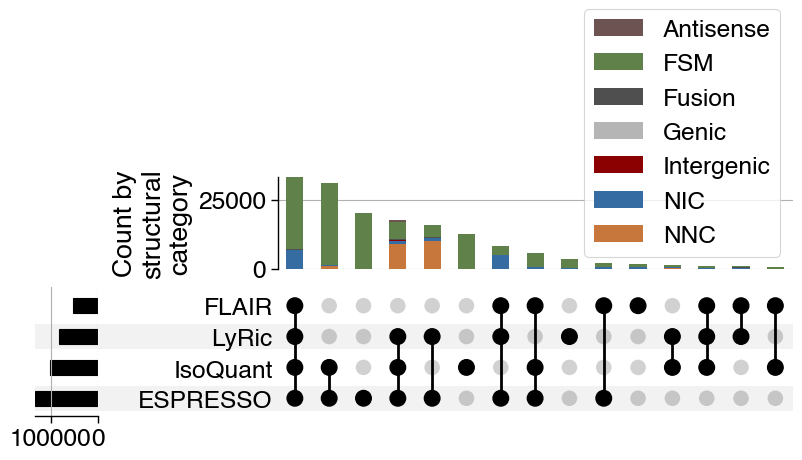

In [8]:
init_plot_settings(font_scale=1.2)
upset = upsetplot.UpSet(mt_df, intersection_plot_elements=0, sort_by='cardinality')  # disable the default bar chart
upset.add_stacked_bars(
    by='structural_category',
    colors=c_dict,
    title='Count by\nstructural\ncategory')
upset.plot()
plt.savefig('transcript_detection_tool_structural_category_poder_upset.pdf', 
            dpi=500)